In [ ]:

#بارگذاری کتابخانه‌ها
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#چک کردن cuda
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


In [ ]:
#تنظیم تبدیلات تصاویر
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#بارگذاری کل دیتاست از پوشه‌ی root (داخلش 22 زیرپوشه دارید)
full_dataset = datasets.ImageFolder('train', transform=transform)

#جدا کردن paths و labels
all_paths  = [s[0] for s in full_dataset.samples]
all_labels = [s[1] for s in full_dataset.samples]

#10% برای تست
paths_trainval, paths_test, lbls_trainval, lbls_test = train_test_split(
    all_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42)

#از 90% باقی‌مانده، 20% برای validation
paths_train, paths_val, lbls_train, lbls_val = train_test_split(
    paths_trainval, lbls_trainval, test_size=0.2, stratify=lbls_trainval, random_state=42)

#تابع کمکی برای ساخت Subset
def make_subset(dataset, paths):
    idxs = [i for i,(p,_) in enumerate(dataset.samples) if p in paths]
    return Subset(dataset, idxs)

train_ds = make_subset(full_dataset, paths_train)
val_ds   = make_subset(full_dataset, paths_val)
test_ds  = make_subset(full_dataset, paths_test)

print(f"Sizes → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")


Sizes → train: 17272, val: 4319, test: 2399


In [ ]:
#ساخت مدل پایه
model = models.resnet50(pretrained=False)
in_features = model.fc.in_features

#جایگزینی لایه‌ی fc برای 22 کلاس
model.fc = nn.Linear(in_features, 22)

#بارگذاری checkpoint (network.pth)
checkpoint = torch.load('food101_model.pth', map_location='cpu')

#حذف وزن‌های قدیمیِ fc از state_dict
for key in ['fc.weight', 'fc.bias']:
    checkpoint.pop(key, None)

#لودِ بقیه‌ی وزن‌ها
model.load_state_dict(checkpoint, strict=False)
print("✅ وزن‌های پیش‌آموزش‌دیده لود شدند (به جز fc).")


d:\food_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\food_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ وزن‌های پیش‌آموزش‌دیده لود شدند (به جز fc).


In [ ]:
#فریز کردن همه‌ی پارامترها
for param in model.parameters():
    param.requires_grad = False

#آنفریز کردن پارامترهای layer4 و fc
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

#انتقال به device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)


Using device: cuda


In [ ]:
#چک‌ کردن اینکه کدام پارامترها آنفریز شدند
for name, param in model.named_parameters():
    print(f"{name:40s} requires_grad = {param.requires_grad}")


conv1.weight                             requires_grad = False
bn1.weight                               requires_grad = False
bn1.bias                                 requires_grad = False
layer1.0.conv1.weight                    requires_grad = False
layer1.0.bn1.weight                      requires_grad = False
layer1.0.bn1.bias                        requires_grad = False
layer1.0.conv2.weight                    requires_grad = False
layer1.0.bn2.weight                      requires_grad = False
layer1.0.bn2.bias                        requires_grad = False
layer1.0.conv3.weight                    requires_grad = False
layer1.0.bn3.weight                      requires_grad = False
layer1.0.bn3.bias                        requires_grad = False
layer1.0.downsample.0.weight             requires_grad = False
layer1.0.downsample.1.weight             requires_grad = False
layer1.0.downsample.1.bias               requires_grad = False
layer1.1.conv1.weight                    requires_grad 

In [6]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

num_epochs = 15
train_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    # --Training--
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # --Validation--
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/15 — Loss: 0.4495, Val Acc: 0.9007
Epoch 2/15 — Loss: 0.3152, Val Acc: 0.9234
Epoch 3/15 — Loss: 0.2984, Val Acc: 0.9324
Epoch 4/15 — Loss: 0.2898, Val Acc: 0.9254
Epoch 5/15 — Loss: 0.2824, Val Acc: 0.9257
Epoch 6/15 — Loss: 0.2690, Val Acc: 0.9187
Epoch 7/15 — Loss: 0.2691, Val Acc: 0.9303
Epoch 8/15 — Loss: 0.2554, Val Acc: 0.9273
Epoch 9/15 — Loss: 0.2483, Val Acc: 0.9310
Epoch 10/15 — Loss: 0.2459, Val Acc: 0.9282
Epoch 11/15 — Loss: 0.2541, Val Acc: 0.9305
Epoch 12/15 — Loss: 0.2247, Val Acc: 0.9289
Epoch 13/15 — Loss: 0.2184, Val Acc: 0.9257
Epoch 14/15 — Loss: 0.2184, Val Acc: 0.9294
Epoch 15/15 — Loss: 0.2189, Val Acc: 0.9329


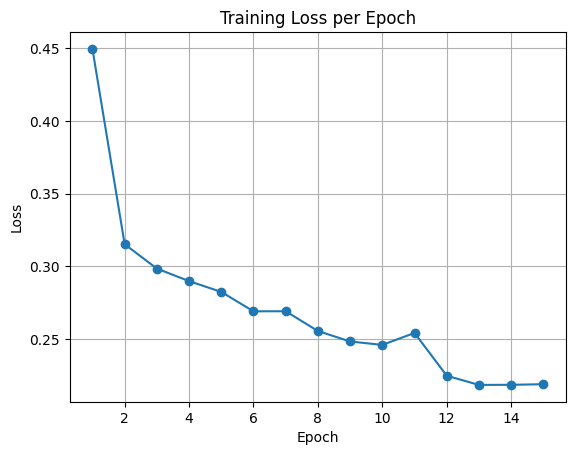

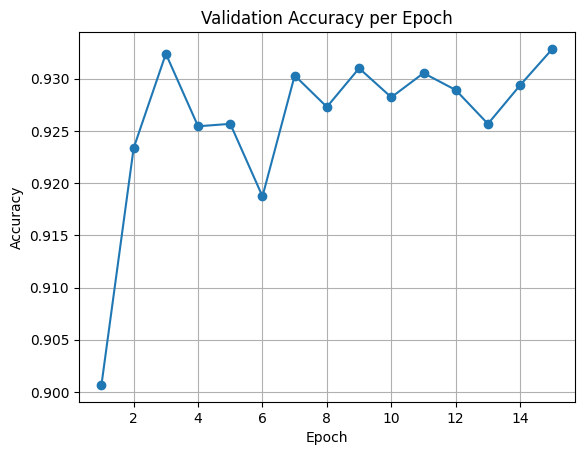

In [8]:
# Training Loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Validation Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


                 precision    recall  f1-score   support

   baked_potato     0.9680    0.8067    0.8800       150
        baklava     0.9054    0.9853    0.9437        68
   caesar_salad     0.9452    0.9718    0.9583        71
cheese_sandwich     0.9155    0.9155    0.9155        71
     cheesecake     1.0000    0.9265    0.9618        68
        chicken     0.9422    0.9381    0.9401       226
  chicken_curry     0.9718    0.9718    0.9718        71
 chocolate_cake     0.8750    1.0000    0.9333        70
         donuts     0.9732    0.9237    0.9478       236
           eggs     0.9589    1.0000    0.9790        70
        falafel     0.9692    0.8873    0.9265        71
           fish     0.9577    0.9577    0.9577        71
   french_fries     0.9208    0.9693    0.9444       228
      hamburger     0.8852    0.9114    0.8981       237
        hot_dog     0.9300    0.8774    0.9029       106
      ice_cream     0.9710    0.9710    0.9710        69
        lasagna     0.9315    

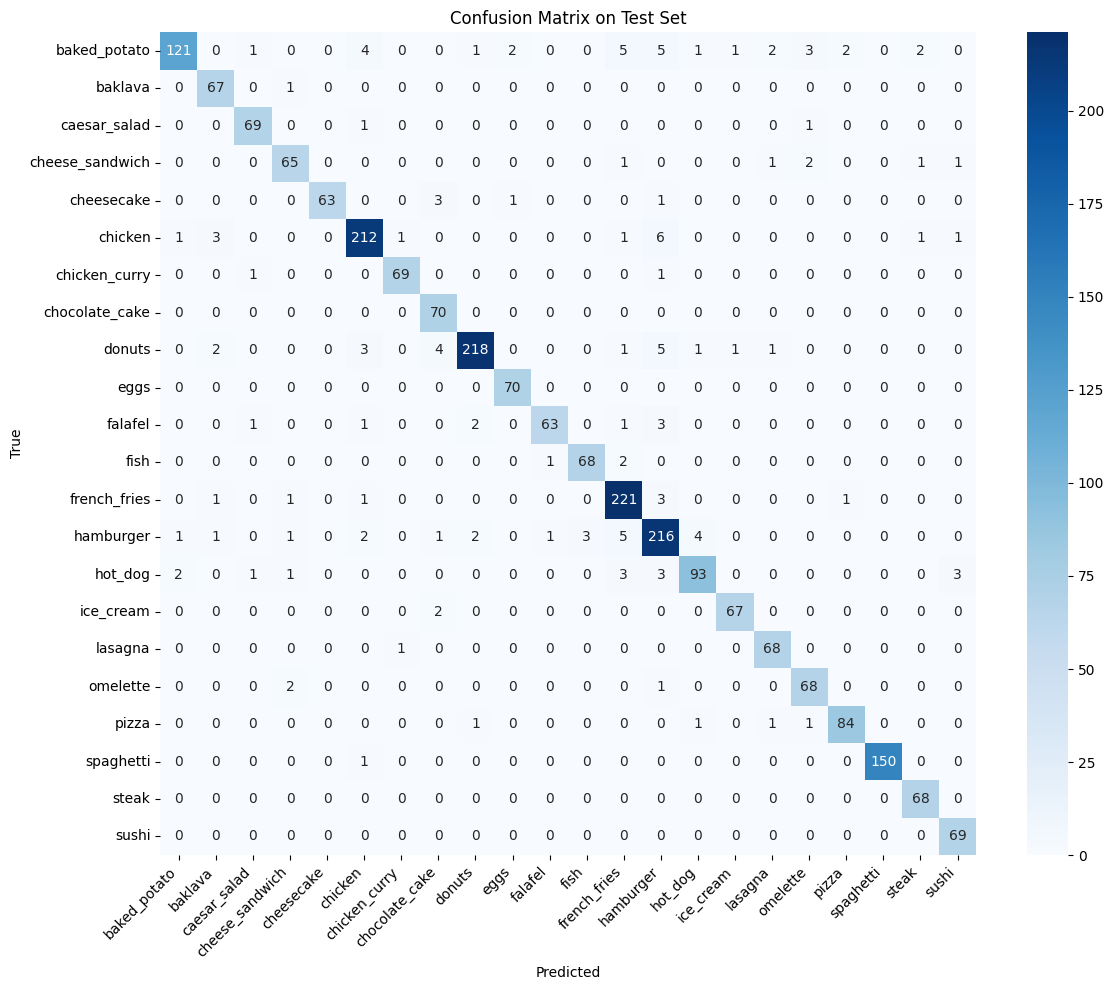

In [ ]:
#پیش‌بینی روی مجموعهٔ تست
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

class_names = full_dataset.classes  # لیست نام 22 کلاس به ترتیب ایندکس

#گزارش طبقه‌بندی با نام کلاس‌ها
print(classification_report(
    all_labels, all_preds,
    target_names=class_names,
    digits=4
))

# ماتریس آشفتگی با تیک‌های نام کلاس
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [11]:
# محاسبهٔ دقت هر کلاس: correct[i] / total[i]
import pandas as pd

num_classes = len(class_names)
correct_per_class = [0]*num_classes
total_per_class   = [0]*num_classes

for true, pred in zip(all_labels, all_preds):
    total_per_class[true] += 1
    if true == pred:
        correct_per_class[true] += 1

per_class_acc = [correct_per_class[i]/total_per_class[i]
                 if total_per_class[i]>0 else 0
                 for i in range(num_classes)]

df_acc = pd.DataFrame({
    "class": class_names,
    "accuracy": per_class_acc,
    "support": total_per_class
})
df_acc = df_acc.sort_values("accuracy", ascending=False).reset_index(drop=True)
df_acc


,class,accuracy,support
0,eggs,1.000000,70
1,chocolate_cake,1.000000,70
2,steak,1.000000,68
3,sushi,1.000000,69
4,spaghetti,0.993377,151
5,lasagna,0.985507,69
6,baklava,0.985294,68
7,caesar_salad,0.971831,71
8,chicken_curry,0.971831,71
9,ice_cream,0.971014,69


ذخیره و استفاده کردن وزن ها

In [12]:
# Cell X: ذخیره‌ی state_dict
save_path = "finetuned_resnet50_state.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ وزن‌ها ذخیره شدند در: {save_path}")


✅ وزن‌ها ذخیره شدند در: finetuned_resnet50_state.pth


In [ ]:
# Cell Y: لود مدل با state_dict
# ۱) مدل را با همان معماری تعریف کن
model2 = models.resnet50(pretrained=False)
model2.fc = nn.Linear(model2.fc.in_features, 22)

# ۲) وزن‌ها را بارگذاری کن
state_path = "finetuned_resnet50_state.pth"
model2.load_state_dict(torch.load(state_path, map_location=device))

# ۳) انتقال به device (GPU/CPU)
model2.to(device)
model2.eval()
print("✅ مدل (state_dict) لود شد و آماده است.")


ذخیره و استفاده کل مدل

In [13]:
# Cell X+1: ذخیره‌ی کل مدل
full_model_path = "finetuned_resnet50_full.pth"
torch.save(model, full_model_path)
print(f"✅ کل مدل ذخیره شد در: {full_model_path}")


✅ کل مدل ذخیره شد در: finetuned_resnet50_full.pth


In [ ]:
# Cell Y+1: لود کل مدل
full_model_path = "finetuned_resnet50_full.pth"
model3 = torch.load(full_model_path, map_location=device)
model3.to(device)
model3.eval()
print("✅ کل مدل لود شد و آماده است.")
